In [70]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

The goal of this notebook is to compare the true value of the variance prediction of an SDE along the trajectory with the one predicted by the Distributional Koopman operator restricted to a different space of observables $H_1 \cup H_2$.
The SDE we are considering is: $$dX_t = a(x) dt + b(x) dB_t$$
and for the observables we select the following: Given radial basis functions $$\hat{h}_i = \phi_{c_i} = e^{-\epsilon (x - c)^2}$$
with centers $c_i \in \{-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2\}$ and $\epsilon = 0.5$. 

Given these we choose basis functions to be $$\left\{\int \hat{h}_i d\pi \int \hat{h}_j d\pi, \int \hat{h}_i\hat{h}_j d\pi\right\}_{i = 1, j = i}^n$$ This is an $n(n + 1)$ dimensional space. 

In [6]:
def euler_maruyama(x0, a, b, T, N):
    """
    implements the euler maruyama method with initial condition x0 and
    coefficients a and b, for time T. The interval [0, T] is partitioned
    in N steps. We impose BC to keep the data within [-2, 2]
    """
    dt = T/N
    y = np.zeros(N + 1)
    y[0] = x0
    for i in range(N):
        y[i + 1] = ( y[i] + np.random.normal()* np.sqrt(dt)*b(y[i]) + a(y[i])* dt +2 )% 4 - 2 
    return y



In [35]:
def variances( a, b, Dt = 0.1, N_sample = 100, N_x0 = 101, T = 11):
    """
        Given the form of the SDE (a, b), the time difference between steps, the number of samples to be used for empirical computation
        of the covariances(N_sample), number of grid points(N_x0) and the time (T)
        of prediction, this function computes the matrix of covariances Cov(K_th_i(x), K_t h_j(x)) for every x and for ever time. 
    """
    # number of observables
    n = 9
    # parameters of radial basis functions
    eps = 0.5
    
    # compute the expectation for N time steps
    N = int((T) /(Dt))
    x0 = np.linspace(-2, 2, N_x0)

    # data_predictions holds for each observale, each grid point and each time, the observation of the sample 
    data_predictions = np.zeros((n, N_x0, N + 1, N_sample))
    for i in range(n):
        c = -2 + i*0.5
        for xx in range(N_x0):
            for repeat in range( N_sample):
                    data_predictions[i, xx, :, repeat] = np.exp(-eps* ( euler_maruyama(x0[xx], a, b, T , N)- c)**2)
    expectations = 1/N_sample * np.sum(data_predictions, axis = 3)

    # compute the covariance matrix where each entry is E[h_i(X_t) h_j(X_t) | X_0 = x] for each grid x, and each time t
    covariances = data_predictions[:, None, :, :, :] * data_predictions[None, :, :, :]                                            
    covariances = 1/N_sample * np.sum(covariances, axis = 4)
    return expectations, covariances

In [28]:
def var_DKO(a, b, distr = "trajectory", K = 100, m = 100, Dt = 0.1, solver_precision = 0.01):
    """
        function that computes the best approximation to the DKO on H_1 U H_1 given: 
        - a, b -> form of the SDE
        - distr -> option for what kind of data should be used
        - K -> number of samples for empirical distribution
        - m -> number of measures
        - Dt -> time difference for the Koopma operator
        - solver_precision -> accuracy of the euler maruyama method
    """
    # dictionary parameters
    n = 9
    eps = 0.5
    # number of samples
    N_DKO = int(m*Dt/solver_precision)      
    T_DKO = Dt*m
    data = np.zeros((K, N_DKO + 1))
    for j in range(K):
        # uncomment this if you want the initial distribution to be a delta at 0
        # x0 = 0

        # uncomment this if you want the initial distribution to be normal
        x_0 = np.random.normal(loc = 0, scale = 1/np.sqrt(2))
        data[j, :] = euler_maruyama(x_0, a, b, T_DKO, N_DKO)
    # DKO data is the trajectory data but with a step of Dt in between
    data = data[:, ::int(Dt/solver_precision)]

    # update the number of points in the data
    (_, N_DKO) = np.shape(data)

    # compute the E and D matrices 
    E = np.zeros(( n*(n + 1), N_DKO - 1))
    D = np.zeros(( n*(n + 1), N_DKO - 1))
    count = 0
    for i in range(n):
        c = -2 + i*0.5
        for j in range(i + 1):
            d = -2 + j*0.5
            phi_linear_data = np.zeros((N_DKO, ))
            phi_quadratic_1 = np.zeros((N_DKO, ))
            phi_quadratic_2 = np.zeros((N_DKO, ))
            for k in range(K):
                phi_linear_data += 1/K*np.exp(-eps* (data[k, :] - c)**2)* np.exp(-eps* (data[k, :] - d)**2)
                phi_quadratic_1 += 1/K*np.exp(-eps* (data[k, :] - c)**2)
                phi_quadratic_2 += 1/K*np.exp(-eps* (data[k, :] - d)**2)
            phi_quadratic_data = phi_quadratic_1 * phi_quadratic_2
            E[count, :] = phi_linear_data[:-1]
            D[count, :] = phi_linear_data[1:]
            E[count + int(n*(n + 1)/2) :] = phi_quadratic_data[:-1]
            D[count + int(n*(n + 1)/2), :] = phi_quadratic_data[1:]
            count = count + 1
    K_DKO = D@np.linalg.pinv(E, rcond = 1e-5)
    return K_DKO


In [45]:
def predictions(K, N_x0 = 101, Dt = 0.1, T = 11):
    """
        It gives the prediction on every basis function for time T, with a difference Dt between times, and on a grid
            consisting on N_x0 grid points. The basis functions are:
            \int h_i(x) h_j(x) d\pi, \int h_i d\pi \int h_j d\pi
    """
    # grid points to evaluate the functions
    x0 = np.linspace(-2, 2, N_x0)

    # number of dictionary functions
    n = 9

    # parameters of radial basis functions
    eps = 0.5
    
    # time duration and number of time steps
    N = int((T ) /(Dt))


    # compute the prediction for the expectation using the Koopman operator

    # array to hold the results dimension 3 represents the time of the prediction, dim 2 is the evaluation point $\delta_x_j$ and 
    # dim 1 is the observable
    
    predictions = np.zeros((n*(n + 1), N_x0, N + 1))

    # matrix H holds for each basis function the starting point 
    H = np.zeros((n*(n + 1), N_x0))
    count = 0
    for i in range(n):
        c = -2 + i*0.5
        for j in range(i + 1):
            d = -2 + j*0.5
            for xx in range(N_x0):
                H[count, xx] = np.exp(-eps* ( x0[xx]- c)**2) * np.exp(-eps* ( x0[xx]- d)**2)
                H[count + int(n*(n + 1)/2), xx] =  np.exp(-eps* ( x0[xx]- c)**2) * np.exp(-eps* ( x0[xx]- d)**2)
            count = count + 1

    predictions[:, :, 0] = H
    for j in range(1, N + 1):
        predictions[:, :, j] = K @ predictions[:, :, j -1] 
    return  predictions

When we asses the prediciton quality we look at the performance on observables that are variances of the original dictionary functions i.e. we want to predict $$ g_i(x) = Var(\hat{h}_i (X_t) | X_0 = x)$$ To judge performance we compute the Mean Square Error: $$MSE_t = \frac{1}{n} \sum_{i = 1}^n \int |Var(\hat{h}_i (X_t) | X_0 = x)  - K^{var}_t Var(\hat{h}_i(X)| X\sim \delta_x) |^2d x $$ where $K_t^{var}$ is the DKO algorithm approximation. 

### 1. State independent noise
$$dX_t =  -sin(2\pi x) dt + dB_t$$

In [37]:
def a(x):
    return - np.sin(2*np.pi*x)
def b(x):
    return 1

In [38]:
# compute the expectaiton and covariances using the definition.
expectations, covariances = variances(a, b)

In [46]:
K_var = var_DKO(a, b)

In [47]:
# compute the variance predictions on the basis functions
pred = predictions(K_var)

We want to asses the quality of the prediction on the variance, so we need to compute the variance truth and variance prediction. We compute the variance by 
$$  Var (\hat{h}_i(X_t) |X_0 = x) = \mathbb{E}[\hat{h}_i^2|X_0 = x] - (\mathbb{E}[\hat{h}_i|X_0 = x])^2$$

The method is the following

- function variances returns
  - expectations = $\mathbb{E}[\hat{h}_i(X_t)|X_0 = x]$ for $i \in \{1, \dots, n\}$ and $x \in [-2, 2]$
  - covariances = $\mathbb{E}[\hat{h}_i(X_t) \hat{h}_j(X_t)|X_0 = x]$
- function predictions returns:
  - pred = $ K_t g_l(\delta_{x})$ for the same $x$ where for $l \leq \frac{n(n + 1)}{2}$ we have $g_l(\pi) = \int \hat{h}_i \hat{h}_j d\pi$ and for $l > \frac{n(n + 1)}{2}$ we have $g_l(\pi) = \int \hat{h}_i d \pi \int \hat{h}_j d\pi$

So the true prediction is $$Var(\hat{h}_j(X_t) | X_0 = x) = covariances[j, j, x, t] - expectations[i, x, t]^2$$ and the predicted variance is
$$K^{var}_t h_j(\delta_x) = pred[j(j + 1)/2 , x, t] - pred[j(j + 1)/2 + n(n + 1)/2, x, t]$$

In [82]:
# number of dictionary functions
(n, N_x0, N_time) = np.shape(expectations)
# compute the variances
i = np.arange(n)
i = i.astype(int)
true_variances = covariances[i, i, :, :] - expectations**2
pred_variances = np.zeros((n, N_x0, N_time))
i = np.arange(1, n + 1)*(np.arange(1, n + 1) +1 ) /2 -1 
i = i.astype(int)
pred_variances = pred[i, :, :] - pred[i+ int(n*(n + 1)/2), :, :]

In [84]:
dx = 4/N_x0
mean_square_error = 1/n* np.sum( integrate.trapezoid((pred_variances-true_variances)**2, dx = dx, axis = 1), axis = 0 )

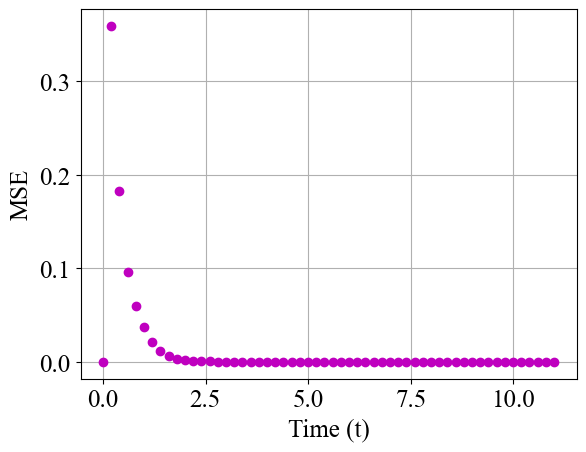

In [101]:
time = np.linspace(0, 11, N_time)
plt.figure()
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})
plt.plot(time[::2], mean_square_error[::2], 'mo')
plt.xlabel("Time (t)")
plt.ylabel("MSE")
plt.grid()

plt.show()

We repeat this experiment many times and compute the statistics


In [96]:
N_exp = 50
results_var = np.zeros((N_exp, N_time))

for repeat in range(N_exp):
    K_var = var_DKO(a, b)
    pred = predictions(K_var)
    i = np.arange(1, n + 1)*(np.arange(1, n + 1) +1 ) /2 -1 
    i = i.astype(int)
    pred_variances = pred[i, :, :] - pred[i+ int(n*(n + 1)/2), :, :]
    mean_square_error = 1/n* np.sum( integrate.trapezoid((pred_variances-true_variances)**2, dx = dx, axis = 1), axis = 0 )
    results_var[repeat, :] = mean_square_error
    

In [97]:
mean_var= np.mean(results_var, axis = 0)
var_var = np.std(results_var, axis = 0)/np.sqrt(N_exp)


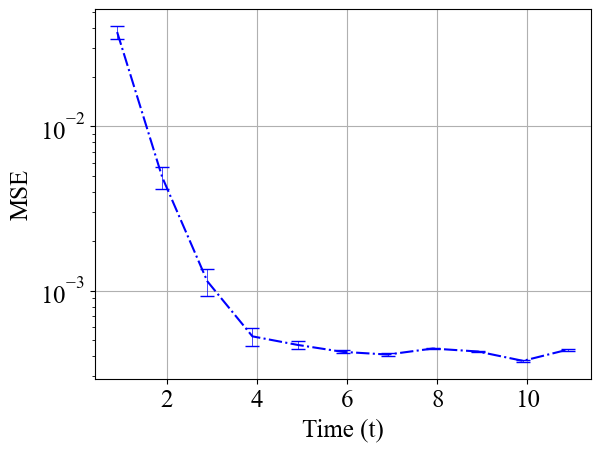

In [98]:
plt.figure()
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})

plt.errorbar(time[9::10], mean_var[9::10], yerr = var_var[9::10],
             linestyle = "-.", color = "blue", capsize = 5, elinewidth = 0.5 )
plt.xlabel("Time (t)")
plt.ylabel("MSE")
plt.yscale("log")
plt.grid()
plt.savefig("state_dependent_variance.png")

### 1. State dependent noise

$$ dX_t =  - \frac{\pi}{2} \sin {0.5\pi x} + \frac{\pi}{4} \sin(\pi x)dt + \sqrt{ 1 + \sin^2(0.5 \pi x)}dB_t$$

In [99]:
def a(x):
    return - (np.pi / 2) * np.sin(np.pi * x / 2) + (np.pi / 4) * np.sin(np.pi * x)
def b(x):
    return np.sqrt(1 + np.sin(np.pi * x / 2)**2)

In [100]:
expectations_indep, covariances_indep = variances(a, b)

In [103]:
K_var_indep = var_DKO(a, b)
pred_indep = predictions(K_var)
(n, N_x0, N_time) = np.shape(expectations_indep)
# compute the variances
i = np.arange(n)
i = i.astype(int)
true_variances_indep = covariances_indep[i, i, :, :] - expectations_indep**2
pred_variances_indep = np.zeros((n, N_x0, N_time))
i = np.arange(1, n + 1)*(np.arange(1, n + 1) +1 ) /2 -1 
i = i.astype(int)
pred_variances_indep = pred_indep[i, :, :] - pred_indep[i+ int(n*(n + 1)/2), :, :]


In [105]:
dx = 4/N_x0
mean_square_error_indep = 1/n* np.sum( integrate.trapezoid((pred_variances_indep-true_variances_indep)**2, dx = dx, axis = 1), axis = 0 )

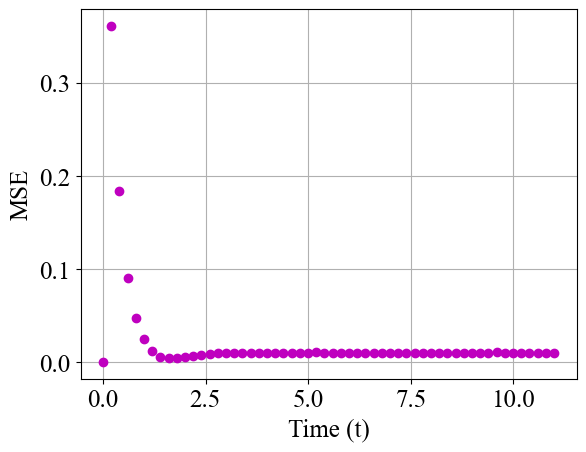

In [106]:
time = np.linspace(0, 11, N_time)
plt.figure()
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})
plt.plot(time[::2], mean_square_error_indep[::2], 'mo')
plt.xlabel("Time (t)")
plt.ylabel("MSE")
plt.grid()

plt.show()

In [107]:
N_exp = 50
results_var_indep = np.zeros((N_exp, N_time))

for repeat in range(N_exp):
    K_var = var_DKO(a, b)
    pred = predictions(K_var)
    i = np.arange(1, n + 1)*(np.arange(1, n + 1) +1 ) /2 -1 
    i = i.astype(int)
    pred_variances = pred[i, :, :] - pred[i+ int(n*(n + 1)/2), :, :]
    mean_square_error = 1/n* np.sum( integrate.trapezoid((pred_variances-true_variances)**2, dx = dx, axis = 1), axis = 0 )
    results_var_indep[repeat, :] = mean_square_error
    

In [110]:
mean_var_indep= np.mean(results_var_indep, axis = 0)
var_var_indep = np.std(results_var_indep, axis = 0)/np.sqrt(N_exp)

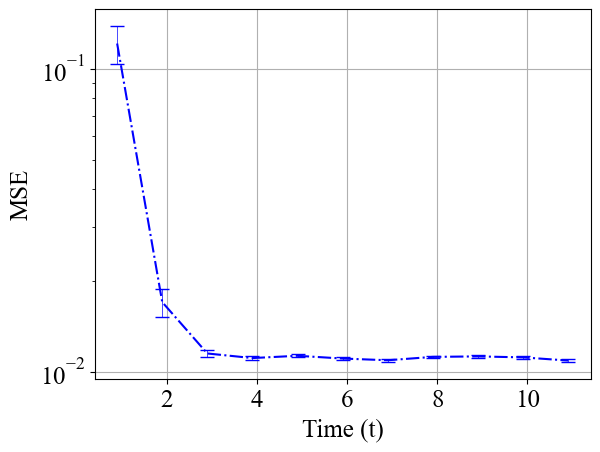

In [113]:
plt.figure()
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})

plt.errorbar(time[9::10], mean_var_indep[9::10], yerr = var_var_indep[9::10],
             linestyle = "-.", color = "blue", capsize = 5, elinewidth = 0.5 )
plt.xlabel("Time (t)")
plt.ylabel("MSE")
plt.yscale("log")
plt.grid()
plt.savefig("state_dependent_variance.png")